In [1]:

import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('all_faults_filtered.csv')

# Segmentar la señal de vibración en pequeñas porciones usando una ventana


In [3]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

win_len=1000
stride=200

X=[]
Y=[]


for k in df['fault'].unique():
    
    df_temp_2 = df[df['fault']==k]
    
    for i in np.arange(0,len(df_temp_2)-(win_len),stride):
        temp = df_temp_2.iloc[i:i+win_len,:-1].values
        temp = temp.reshape((1,-1))
        X.append(temp)
        Y.append(df_temp_2.iloc[i+win_len,-1])
    
X=np.array(X)
X=X.reshape((X.shape[0],win_len))



Y=np.array(Y)
encoder= LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

In [4]:
X.shape

(13848, 1000)

# Dividir los datos en entrenar y probar

In [5]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.25,shuffle=True)


# Visualizar los datos usando t-sne antes de usar codificadores automáticos

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 13848 samples in 0.031s...
[t-SNE] Computed neighbors for 13848 samples in 8.758s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13848
[t-SNE] Computed conditional probabilities for sample 2000 / 13848
[t-SNE] Computed conditional probabilities for sample 3000 / 13848
[t-SNE] Computed conditional probabilities for sample 4000 / 13848
[t-SNE] Computed conditional probabilities for sample 5000 / 13848
[t-SNE] Computed conditional probabilities for sample 6000 / 13848
[t-SNE] Computed conditional probabilities for sample 7000 / 13848
[t-SNE] Computed conditional probabilities for sample 8000 / 13848
[t-SNE] Computed conditional probabilities for sample 9000 / 13848
[t-SNE] Computed conditional probabilities for sample 10000 / 13848
[t-SNE] Computed conditional probabilities for sample 11000 / 13848
[t-SNE] Computed conditional probabilities for sample 12000 / 13848
[t-SNE] Computed conditional probabilities for sa

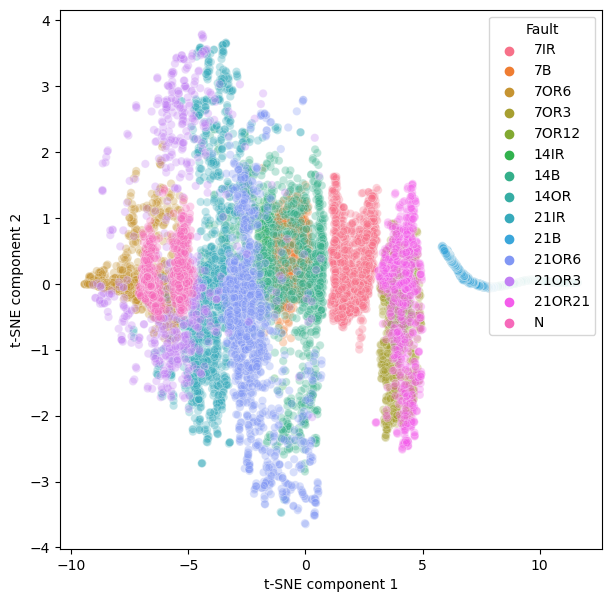

In [6]:
X_pre_aen = X

from sklearn.manifold import TSNE

X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(X_pre_aen)

tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['t-SNE component 1', 't-SNE component 2'])

tSNEdf['Fault']=Y


# Plot the PC-1 and PC-2
fig, ax = plt.subplots(figsize=(7,7))
sns.scatterplot(x=tSNEdf['t-SNE component 1'],y=tSNEdf['t-SNE component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()

In [7]:
tSNEdf

,t-SNE component 1,t-SNE component 2,Fault
0,1.677142,-0.186991,7IR
1,2.636844,0.660284,7IR
2,1.862015,0.089320,7IR
3,2.715260,1.167849,7IR
4,2.953722,0.716867,7IR
...,...,...,...
13843,-6.525592,-0.172318,N
13844,-5.202087,0.588852,N
13845,-6.667678,0.086549,N
13846,-5.312728,0.329620,N


In [8]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten


# from tensorflow.keras.models import load_model
# AE_model = load_model(r'Trained Model\AE_model_gear.h5')


no_classes=len(encoder.classes_)
# build a model
model = Sequential()
model.add(Dense(1024, input_shape=(X.shape[1],), activation='relu')) # input shape is (features,)
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(no_classes, activation='softmax'))
model.summary()

# compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', # this is different instead of binary_crossentropy (for regular classification)
              metrics=['accuracy'])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              1025024   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 14)                1806      
                                                                 
Total params: 1,715,854
Trainable params: 1,715,854
Non-trainable params: 0
_________________________________________________________________


In [9]:
history = model.fit(X_train,
                    y_train,
                    epochs=50, # you can set this to a big number!
                    batch_size=500,
                    shuffle=True,
                    validation_data=(X_test,y_test),
                    verbose=1)

Epoch 1/50
21/21 [==============================] - 5s 77ms/step - loss: 1.8961 - accuracy: 0.3027 - val_loss: 1.2611 - val_accuracy: 0.5040
Epoch 2/50
21/21 [==============================] - 1s 57ms/step - loss: 0.9940 - accuracy: 0.6569 - val_loss: 0.7051 - val_accuracy: 0.7311
Epoch 3/50
21/21 [==============================] - 1s 55ms/step - loss: 0.5509 - accuracy: 0.7912 - val_loss: 0.5673 - val_accuracy: 0.7718
Epoch 4/50
21/21 [==============================] - 1s 55ms/step - loss: 0.3672 - accuracy: 0.8588 - val_loss: 0.2669 - val_accuracy: 0.8865
Epoch 5/50
21/21 [==============================] - 1s 54ms/step - loss: 0.2218 - accuracy: 0.9184 - val_loss: 0.2224 - val_accuracy: 0.9148
Epoch 6/50
21/21 [==============================] - 1s 53ms/step - loss: 0.1685 - accuracy: 0.9420 - val_loss: 0.1849 - val_accuracy: 0.9252
Epoch 7/50
21/21 [==============================] - 1s 55ms/step - loss: 0.1544 - accuracy: 0.9429 - val_loss: 0.1834 - val_accuracy: 0.9249
Epoch 8/50
21

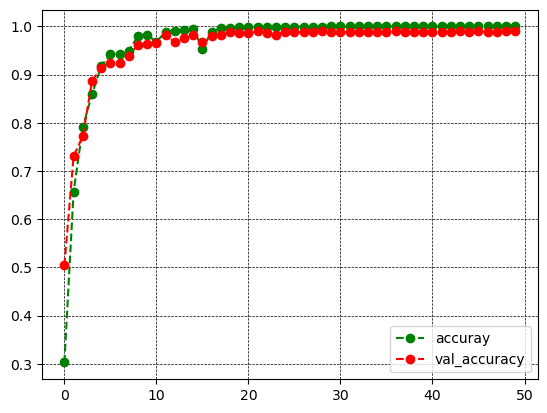

In [10]:
plt.plot(history.history['accuracy'],'go--')
plt.plot(history.history['val_accuracy'],'ro--')
plt.legend(['accuray','val_accuracy'])
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.show()

109/109 [==============================] - 3s 7ms/step


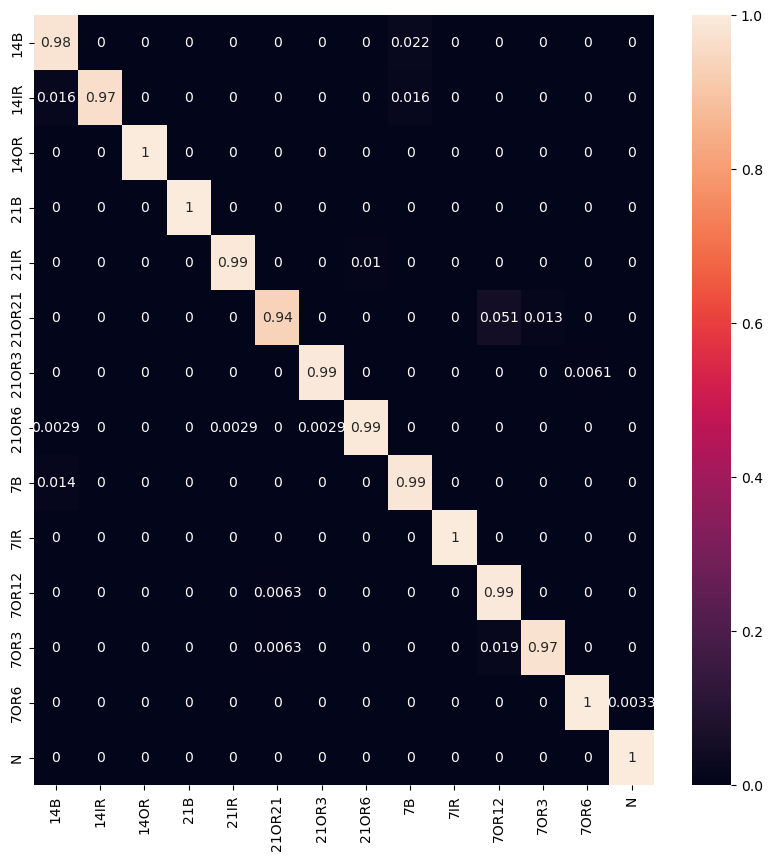

In [22]:
def inv_Transform_result(y_pred):    
    y_pred = y_pred.argmax(axis=1)
    y_pred = encoder.inverse_transform(y_pred)
    return y_pred



y_pred=model.predict(X_test)


Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)




from sklearn.metrics import confusion_matrix


plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True,xticklabels=encoder.classes_,yticklabels=encoder.classes_)
plt.show()

In [12]:
dummy_ann = Model(inputs=model.input,outputs=model.layers[-2].output)
y_viz = dummy_ann.predict(X_train)

325/325 [==============================] - 1s 4ms/step


In [13]:
y_viz.shape

(10386, 128)

In [14]:
def T_SNE_plot(X_train,y_train,model,encoder):
    
    dummy_ann = Model(inputs=model.input,outputs=model.layers[-2].output)
    y_viz = dummy_ann.predict(X_train)
    
    from sklearn.manifold import TSNE

    X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

    tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['T-SNE component 1', 'T-SNE component 2'])

    tSNEdf['Fault']=inv_Transform_result(y_train)


    # Plot the PC-1 and PC-2
    fig, ax = plt.subplots(figsize=(10,10))
    sns.scatterplot(x=tSNEdf['T-SNE component 1'],y=tSNEdf['T-SNE component 2'],hue='Fault',
        data=tSNEdf,
        legend="full",
        alpha=0.3)
    plt.show()

325/325 [==============================] - 1s 4ms/step
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10386 samples in 0.000s...
[t-SNE] Computed neighbors for 10386 samples in 1.286s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10386
[t-SNE] Computed conditional probabilities for sample 2000 / 10386
[t-SNE] Computed conditional probabilities for sample 3000 / 10386
[t-SNE] Computed conditional probabilities for sample 4000 / 10386
[t-SNE] Computed conditional probabilities for sample 5000 / 10386
[t-SNE] Computed conditional probabilities for sample 6000 / 10386
[t-SNE] Computed conditional probabilities for sample 7000 / 10386
[t-SNE] Computed conditional probabilities for sample 8000 / 10386
[t-SNE] Computed conditional probabilities for sample 9000 / 10386
[t-SNE] Computed conditional probabilities for sample 10000 / 10386
[t-SNE] Computed conditional probabilities for sample 10386 / 10386
[t-SNE] Mean sigma: 2.649277
[t-SNE] KL divergence after 250 i

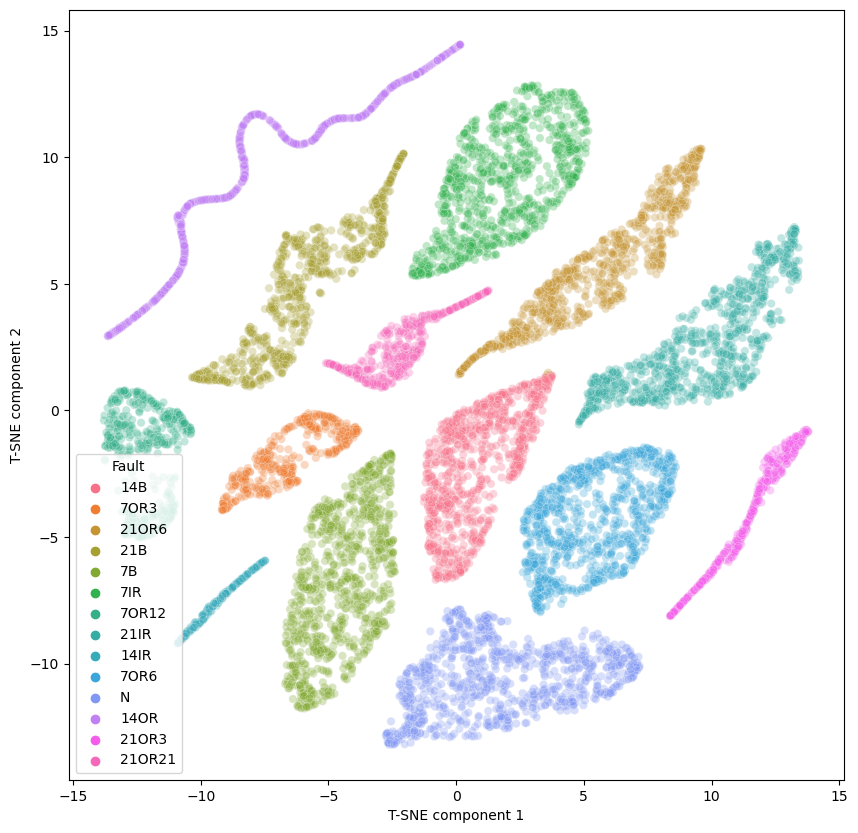

In [15]:
T_SNE_plot(X_train,y_train,model,encoder)

In [16]:
def Test_model_diff_loading(load,win_len,stride,model):
    
    df = pd.read_csv('{}hp_all_faults.csv'.format(load))

#     win_len=1000
#     stride=200

    X=[]
    Y=[]


    for k in df['fault'].unique():

        df_temp_2 = df[df['fault']==k]

        for i in np.arange(0,len(df_temp_2)-(win_len),stride):
            temp = df_temp_2.iloc[i:i+win_len,:-1].values
            temp = temp.reshape((1,-1))
            X.append(temp)
            Y.append(df_temp_2.iloc[i+win_len,-1])

    X=np.array(X)
    X=X.reshape((X.shape[0],win_len))



    Y=np.array(Y)
    encoder2= LabelEncoder()
    encoder2.fit(Y)
    encoded_Y = encoder2.transform(Y)
    OHE_Y = to_categorical(encoded_Y)


    def inv_Transform_result(y_pred,encoder):    
        y_pred = y_pred.argmax(axis=1)
        y_pred = encoder.inverse_transform(y_pred)
        return y_pred



    y_pred=model.predict(X)
    
    print('Accuracy on Load-{}hp data is---{}%'.format(load,(model.evaluate(X,OHE_Y)[1])*100))


    Y_pred=inv_Transform_result(y_pred,encoder2)
    Y_test = Y

    from sklearn.metrics import confusion_matrix


    plt.figure(figsize=(10,10))
    cm = confusion_matrix(Y_test, Y_pred,normalize='true')
    f = sns.heatmap(cm, annot=True,xticklabels=encoder.classes_,yticklabels=encoder.classes_)
    plt.show()
    print()
    
    T_SNE_plot(X[::10,:],OHE_Y[::10,:],model,encoder2)

In [18]:
Test_model_diff_loading(load=1,win_len=1000,stride=200,model=model)

FileNotFoundError: [Errno 2] No such file or directory: '1hp_all_faults.csv'

In [19]:
Test_model_diff_loading(load=2,win_len=1000,stride=200,model=model)

FileNotFoundError: [Errno 2] No such file or directory: '2hp_all_faults.csv'

In [20]:
Test_model_diff_loading(load=3,win_len=1000,stride=200,model=model)

FileNotFoundError: [Errno 2] No such file or directory: '3hp_all_faults.csv'